<p>Name: Benjamin Weckerle</p>
<p>Email: bpw1009@wildcats.unh.edu</p>


In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import numpy as np
import scipy
from scipy.stats import ttest_ind
import sklearn
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
# Read csv file that has been saved locally
orders = pd.read_csv("C:/Users/Ben/Desktop/UNH Classes/Job Search/screening_exercise_orders_v201810.csv")

<h1>Question A:</h1>
    <p> Assemble a dataframe with one row per customer and the following columns: </p>
    <ul>
    <li>customer_id</li>
    <li>gender</li>
    <li>most_recent_order_date</li>
    <li>order_count (number of orders placed by this customer)</li>
    </ul>
   <p>Sort the dataframe by customer_id ascending and display the first 10 rows.</p>


In [3]:
# Groupby to get count of orders per customer
order_count = orders.groupby(['customer_id']).size().reset_index(name='order_count')

# Grouby to get the most recent order date for each customer
order_date = orders.groupby(by=['customer_id'])['date'].max().reset_index()

# Convert date to pandas datetime, remove the time from the datetime, and rename column
order_date['date'] = pd.to_datetime(order_date['date'])
order_date['date'] = order_date['date'].dt.date
order_date.columns = ['customer_id','most_recent_order_date']

# Select the customer_id and gender columns
order_gender = orders[['customer_id', 'gender']]
# Voting system to choose the gender by most common gender value (mode) for each customer. Apply lambda function
# This could also be used, if the actual gender column didn't exist, to select the gender from the most commonly predicted gender
OG = pd.DataFrame(order_gender.groupby('customer_id').gender.apply(lambda x: x.mode()))

# Left join order_date to order_count with customer_id as key
join1 = pd.merge(order_count, order_date, how='left', on='customer_id')

# Left join gender to the previous join with customer_id as key
join2 = pd.merge(join1, OG, how='left', on='customer_id')

# Make sure the dataframe is sorted by customer_id in ascending order
answer_A = join2.sort_values('customer_id', ascending=True)
# Reorder the columns
answer_A = answer_A[['customer_id', 'gender', 'most_recent_order_date', 'order_count']]

# Print the first 10 rows
answer_A.head(10)

,customer_id,gender,most_recent_order_date,order_count
0,1000,0,2017-01-01,1
1,1001,0,2017-01-01,1
2,1002,1,2017-02-19,3
3,1003,1,2017-04-26,4
4,1004,0,2017-01-01,1
5,1005,1,2017-12-16,2
6,1006,1,2017-05-09,3
7,1007,0,2017-01-01,1
8,1008,0,2017-12-17,3
9,1009,1,2017-01-01,1


<h1>Question B:</h1>
    <p>Plot the count of orders per week.</p>

In [4]:
# Create a dataframe orders2 to start Question B
orders2 = orders

# Change date column to pandas datetime format
orders2['date'] = pd.to_datetime(orders2['date'])

# Drop the time from the date column
orders2['date'] = orders2['date'].dt.date

# Groupby date to get the number of orders per day
order_count2 = orders2.groupby(['date']).size().reset_index(name='order_count')

# Set the index as the date
order_count2.set_index(pd.DatetimeIndex(order_count2['date']),inplace=True)

# Drop the date column from within the dataframe since we have a date index
order_count2 = order_count2.drop(['date'],axis=1)

# Use resample to group index by week
orders_by_week = order_count2.resample('W').sum()

# Rename the index to reflect the week grouping
orders_by_week = orders_by_week.rename_axis('week_starting')

# Inspect the resulting dataframe
orders_by_week.head()

,order_count
week_starting,
2017-01-01,14
2017-01-08,180
2017-01-15,264
2017-01-22,405
2017-01-29,233


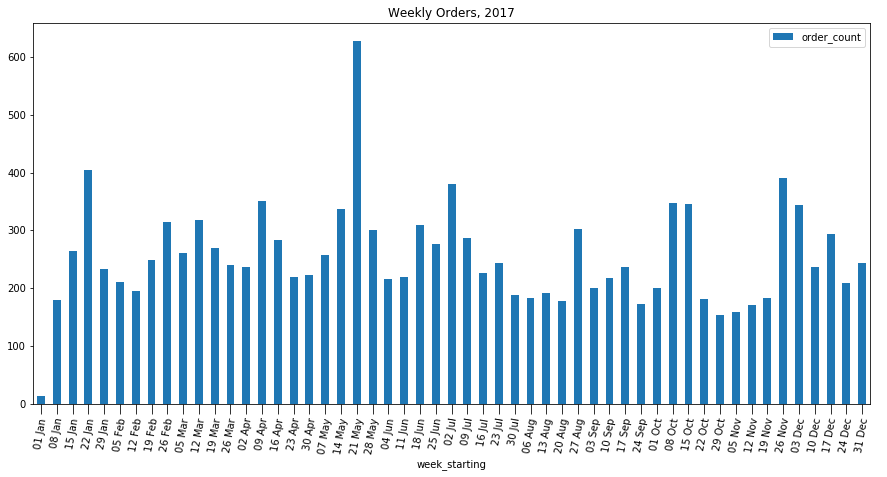

In [5]:
# Initialize matplotlib and set size of plot
fig, ax = plt.subplots(figsize=(15,7))

# Set the type of plot to bar chart
orders_by_week.plot(kind = 'bar', ax=ax)

# Set the title
ax.set_title('Weekly Orders, 2017')

# Format the X-axis tick marks and labels
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(orders_by_week.index.to_series().dt.strftime("%d %b")))

# Adjust the label rotation and label size as well as the tick mark size for X-axis
ax.xaxis.set_tick_params(rotation=80, labelsize=10, size=10)


<h1>Question C:</h1>
    <p>Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant?</p>
    

In [6]:
# Create a dataframe orders2 to start Question C
orders3 = orders


gen_0 = orders3[orders3['gender'] == 0]
gen_0_ave = round((sum(gen_0['value']))/(len(gen_0)),2)
print("The mean order-value for gender 0 is $" + str(gen_0_ave) + ".")

gen_1 = orders3[orders3['gender'] == 1]
gen_1_ave = round((sum(gen_1['value']))/(len(gen_1)),2)
print("The mean order-value for gender 1 is $" + str(gen_1_ave) + ".")



The mean order-value for gender 0 is $363.89.
The mean order-value for gender 1 is $350.71.


<p>Although the question doesn't explicitly ask for <i><b>statistical</b></i> significance, I will perform a 2 sample (Welch's) t-test as a standard method of checking for a difference between two populations.</p>
<h4>Null Hypothesis: Gender 0 and Gender 1 spend the same amount per order.</h4>
<h4>Alternate Hypothesis: Gender 0 and Gender 1 spend different amounts per order.</h4>

In [7]:
# Use scipy stats to perform Welch's t-test
scipy.stats.ttest_ind(gen_0['value'], gen_1['value'], equal_var=False)

Ttest_indResult(statistic=1.976107933576866, pvalue=0.04816296295128402)

<p>The <b>p-value</b> of <b>0.04816</b> is just under the traditional alpha level of <b>0.05</b> used to reject a null hypothesis. However, use of this alpha level has come under extreme scrutiny in recent years and has been cited as contributing factor for the <i><b>Reproducibility Crisis</b></i> in traditional statistics. Therefore, I will note that there is <b>weak evidence</b> of a difference between the populations but <b>will not reject the null hypothesis in favor of the alternative</b>. To directly answer the question asked, I would <i><b>not</b></i> say the difference is significant.</p>

<h1>Question D:</h1>
    <p>Assuming a single gender prediction was made for each customer, generate a confusion matrix for predicted gender. What does the confusion matrix tell you about the quality of the predictions?</p>
    

Confusion matrix, without normalization
[[2189 2218]
 [ 895 3512]]


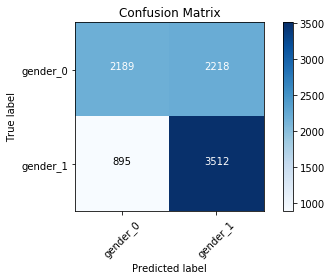

The accuracy of the model is: 0.6468
The misclassification rate of the model is: 0.3532
The true positive rate or recall of the model is: 0.7969
The false positive rate of the model is: 0.5033
The true negative rate or specificity of the model is: 0.4967
The precision of the model is: 0.6129
The prevalence of the model is: 0.6501


In [8]:
# Define a function for plotting a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Use groupby to limit rows to one row for every customer_id with the customers' actual gender
order_genders = pd.DataFrame(orders.groupby(['customer_id'])['gender'].first()).reset_index()

# Voting system to select the most commonly predicted gender (mode) for each customer. Apply lambda function
pred_genders = pd.DataFrame(orders.groupby('customer_id').predicted_gender.apply(lambda x: x.mode()))

#Left join predicted genders to actual genders
merg = pd.merge(order_genders, pred_genders, how='left', on='customer_id')

cnf_matrix = confusion_matrix(merg['gender'],merg['predicted_gender'])

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['gender_0','gender_1'], title='Confusion Matrix')
plt.show()

# Calculations outsided of confusion matrix function
TP = len(merg[(merg['gender'] == 1) & (merg['predicted_gender'] == 1)])
FP = len(merg[(merg['gender'] == 0) & (merg['predicted_gender'] == 1)])
TN = len(merg[(merg['gender'] == 0) & (merg['predicted_gender'] == 0)])
FN = len(merg[(merg['gender'] == 1) & (merg['predicted_gender'] == 0)])
print("The accuracy of the model is: " + str(round((TP+TN)/(TP+FP+TN+FN),4)))
print("The misclassification rate of the model is: " + str(round((FP+FN)/(TP+FP+TN+FN),4)))
print("The true positive rate or recall of the model is: " + str(round(TP/(len(merg[(merg['gender'] == 1)])),4)))
print("The false positive rate of the model is: " + str(round(FP/(len(merg[(merg['gender'] == 0)])),4)))
print("The true negative rate or specificity of the model is: " + str(round(TN/(len(merg[(merg['gender'] == 0)])),4)))
print("The precision of the model is: " + str(round(TP/(len(merg[(merg['predicted_gender'] == 1)])),4)))
print("The prevalence of the model is: " + str(round((len(merg[(merg['predicted_gender'] == 1)]))/(TP+FP+TN+FN),4)))

<p>We can look at the confusion matrix and to related metrics in order to evaluate the quality of predictions of a classification model. In this case, which doesn't have an actual positive or negative test result (genders are neither positive nor negative), we will arbitrarily refer to <b>gender 0</b> as <b>negative</b> and <b>gender 1</b> as <b>positive</b>.</p>
<p> The confusion matrix has four sections: the uppper left represents true negatives, the lower left represents false negatives, the upper right represents false positives, and the lower right represents true positives.</p>
<p>We are able to see that the model performs poorly overall. The overall accuracy, while marginally better than flipping a coin, is only about 65% accurate and should not be used in production. The various other rates inform us how well the model performed in relation to actual vs. predicted values. For instance, recall shows how often the model predicted gender 1 when the value was actually gender 1. Recall was the least problematic area for these predictions reaching about 80%. Aside from recall, the measures all tell us that the quality of the predictions is unreliable.</p>

<h1>Question E:</h1>
<p>Describe one of your favorite tools or techniques and give a small example of how it's helped you solve a problem. Limit your answer to one paragraph.</p>

One of my favorite tools for data science is the Scikit-learn machine learning library. I am grateful for the work that people have put into the project. It's incredible how many algorithms and preprocessing tools are available and how well documented they are. I realize that data science must make progress by abstracting away lower levels of programming. This allows machine learning tasks to be processed at a much faster rate--focusing on the problems at hand rather than recoding something that's been done hundreds or thousands of times before. An example of how I have used Scikit-learn is for topic modeling with Latent Dirichlet Allocation (LDA) on the Enron email corpus. While I did research how LDA works, having the algorithm available on Scikit-learn saved me dozens of hours of debugging. Helping me get to the final product much faster. 

# PK's feedback: 

It's ok to use different variables while figuring out the problem, but I should reuse variables when I send the code for a job application so I don't store extra variables in memory.

For the statistical significance question, maybe use a practical significance as well as a statistical significance. Absolute difference...

PK noticed a clear difference in the comments for the confusion matrix. He said it was obvious that I copied (from sklearn docs) that since there were no comments. I should have added comments in the other parts. It can seem like I don't understand that part of the code.

Use a label for the Y variable for the matplotlib bar chart. 

USE BETTER VARIABLE NAMES